<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/Models/notebooks/Model_E/Set_1_5_Model_E_ret_epoch100_oct16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Set_1_5 merged dataset, annotated, split in train/valid/test.

Train Model_D using Set_1_5 to generate Model_E.

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [2]:
exit()

In [ ]:
import icevision

In [2]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.10.0a1
torch v 1.9.0+cu111
torchvision v 0.10.0+cu111


Use annotated Set_1_5

In [ ]:
! git clone https://github.com/yrodriguezmd/Surgical_instruments.git

In [4]:
!ls Surgical_instruments/Sets/Set_S/annotated
# merged dataset in Set_S contains Sets 1 - 5

README.md  test  train	valid


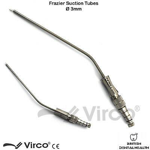

In [5]:
image_path = Path('Surgical_instruments/Sets/Set_S/annotated/train')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[401]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [6]:
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)
len(class_map)

16

Parse data

In [12]:
# temporary
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [14]:
#!ls Surgical_instruments/Sets/Set_S/annotations/train
!ls gdrive/MyDrive/Surgical_instruments/Set_1_5.v1i.coco

README.dataset.txt  README.roboflow.txt  test  train  valid


In [16]:
#path = Path('Surgical_instruments/Sets/Set_S/') # adjust if use git clone vs gdrive
path = Path('gdrive/MyDrive/Surgical_instruments/Set_1_5.v1i.coco')

train_parser = parsers.COCOBBoxParser(
    #annotations_filepath = path/'annotations/train/Set_1_5_annotations.coco.json',
    annotations_filepath = path/'train/Set_1_5_annotations.coco.json',
    img_dir = path/'train'
    #img_dir = path/'annotated/train'
)

valid_parser = parsers.COCOBBoxParser(
    #annotations_filepath = path/'annotations/valid/Set_1_5_annotations.coco.json',
    annotations_filepath = path/'valid/Set_1_5_annotations.coco.json',
    img_dir = path/'valid'
    #img_dir = path/'annotated/valid'
)

In [17]:
# dataset already split in annotation tool, maintain grouping

whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

  0%|          | 0/595 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/132 [00:00<?, ?it/s]

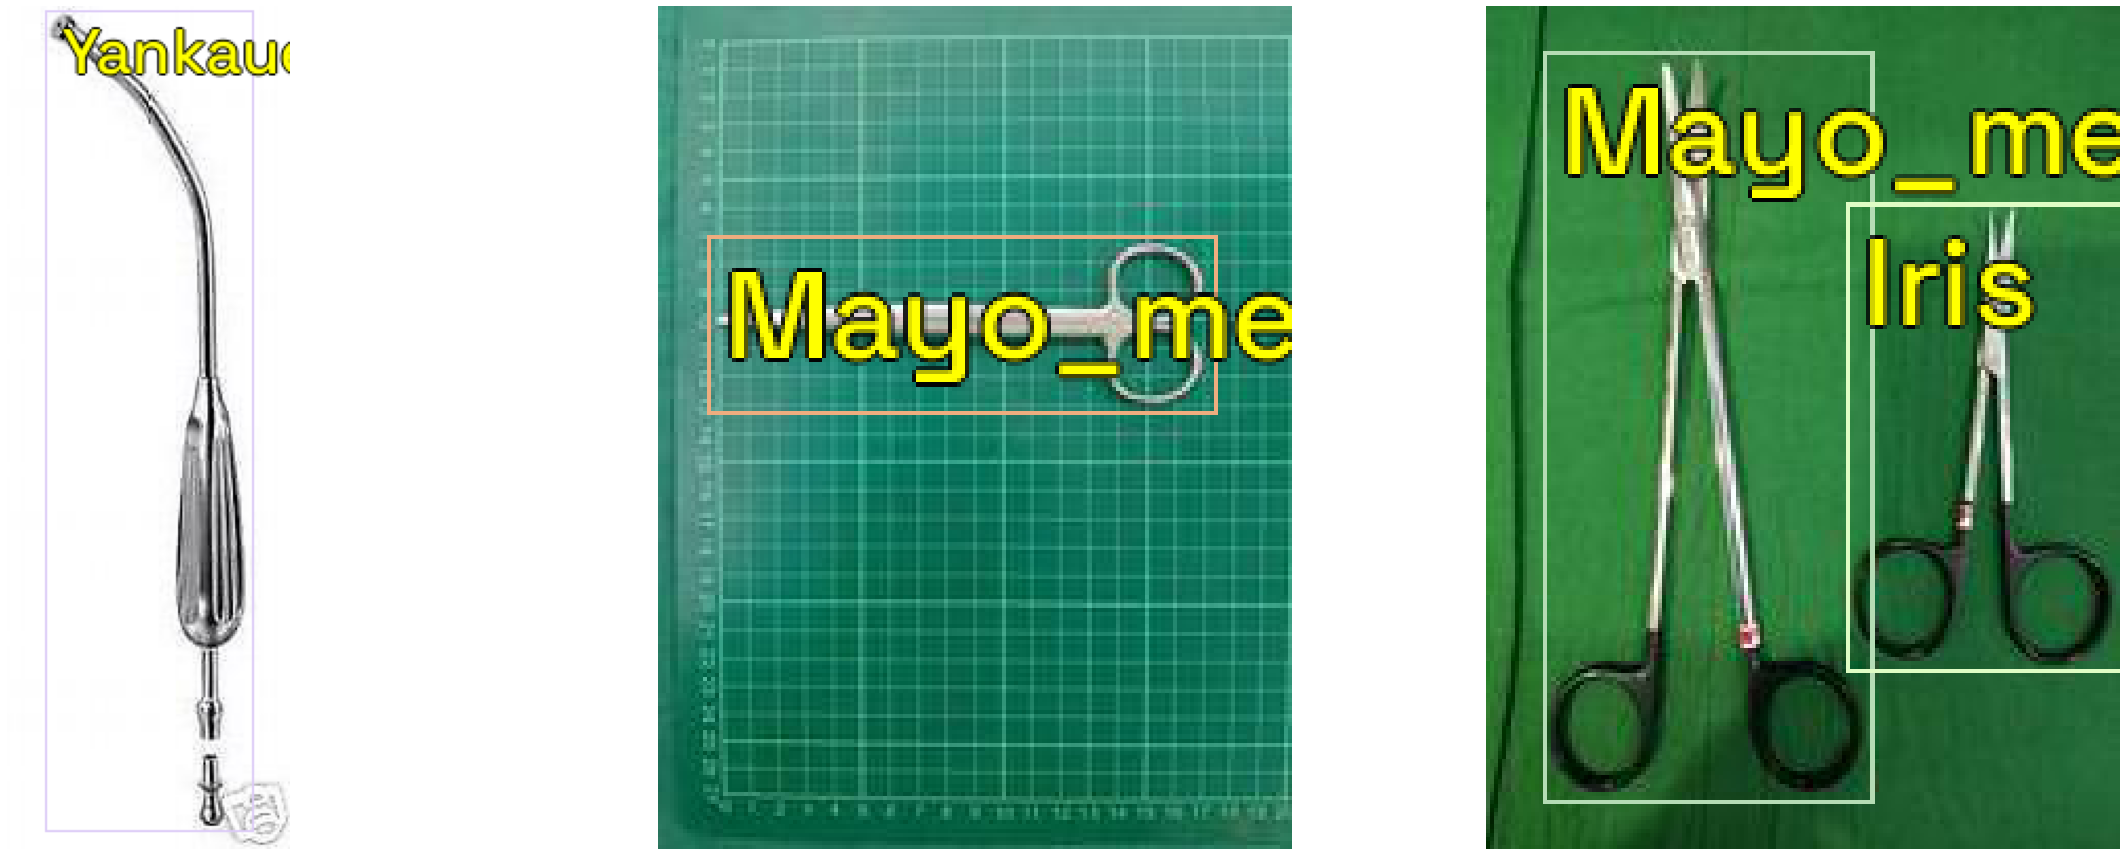

In [18]:
show_records(train_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

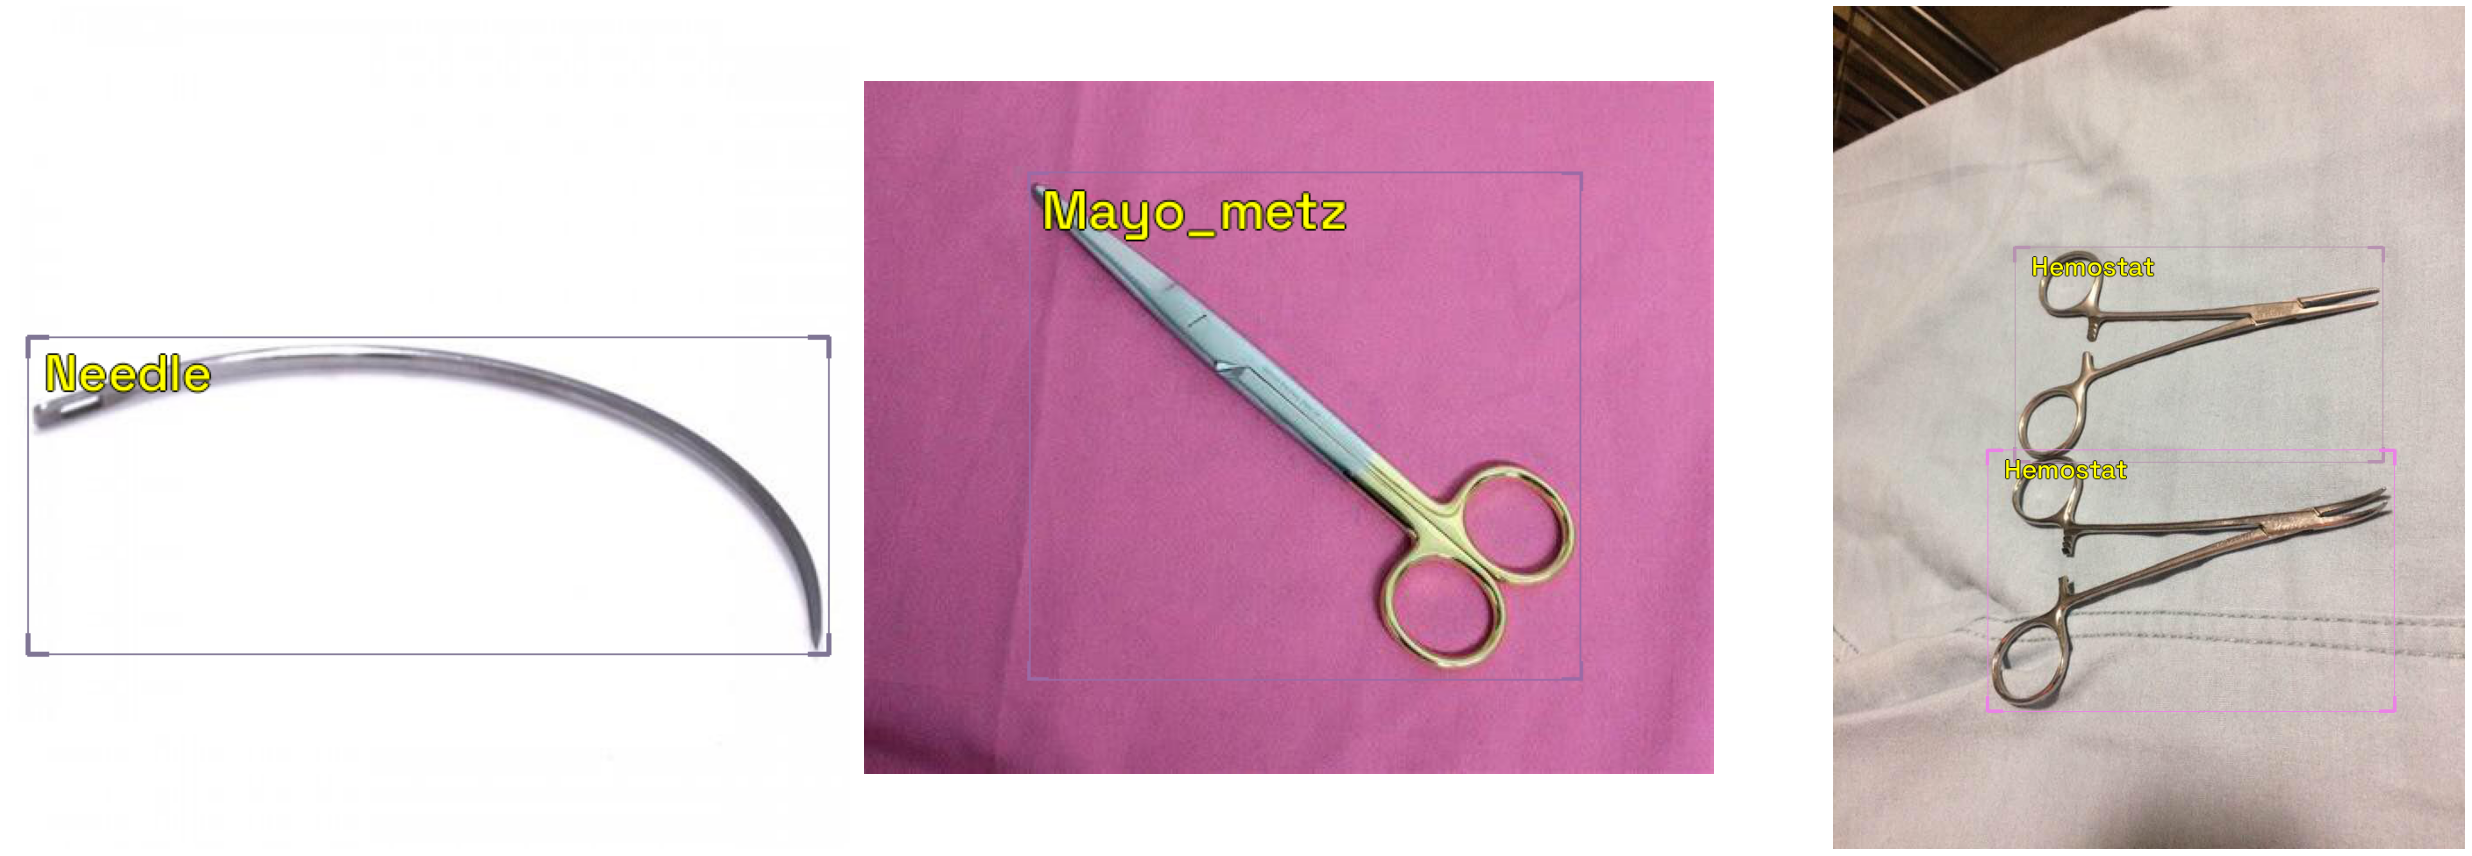

In [19]:
show_records(valid_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

In [20]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [21]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Train Model_D to generate teacher Model_E using Set_1_5 merged.  

In [22]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

from icevision.models.checkpoint import *

model_type = models.mmdet.retinanet ##
backbone = model_type.backbones.resnet50_fpn_1x##

#model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(classes),)# **extra_args)

In [23]:
# temporary
from google.colab import files
files.upload()

Saving Model_D_ret_mAP48.9.pth to Model_D_ret_mAP48.9.pth


In [ ]:
checkpoint_path = 'Model_D_ret_mAP48.9.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model = checkpoint_and_model['model']
model.train()

In [25]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [27]:
##
from fastai.callback.wandb import *

wandb.init(project = 'Surgical_instruments', name = 'Model_E_Set_1_5', ##
           reinit = True)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback()) ##

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.00013182566908653826)

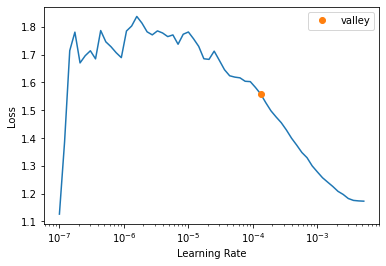

In [29]:
learn.lr_find()

In [30]:
# Set 1_4, retinanet, 
learn.fine_tune(100,1.3e-4)

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,1.040060,0.716179,0.239439,00:31


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,0.430888,0.597680,0.275725,00:32
1,0.386602,0.555595,0.329320,00:31
2,0.344272,0.527541,0.352839,00:32
3,0.307110,0.513668,0.371608,00:31
4,0.295462,0.505342,0.401130,00:31
5,0.273364,0.501830,0.400448,00:31
6,0.252948,0.502232,0.391529,00:31
7,0.238166,0.479479,0.421251,00:31
8,0.225303,0.491260,0.437901,00:31
9,0.214500,0.516620,0.420827,00:31


In [31]:
import matplotlib.pyplot as plt
def plot_metrics(learn, title):
  plt.plot(L(learn.recorder.values).itemgot())
  plt.xlabel('epoch')
  plt.ylabel('mAP (green), Loss (blue, orange)')
  plt.title(title)
  plt.text(0,-0.2, 
       'Legend: mAP(green), train_loss(blue), valid_loss(orange')
  plt.ylim(0,1);

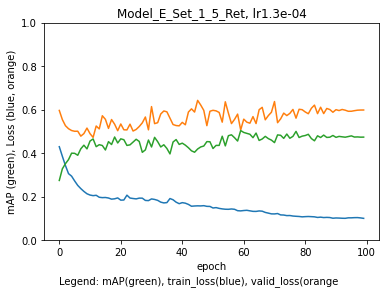

In [32]:
plot_metrics(learn, 'Model_E_Set_1_5_Ret, lr1.3e-04')

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


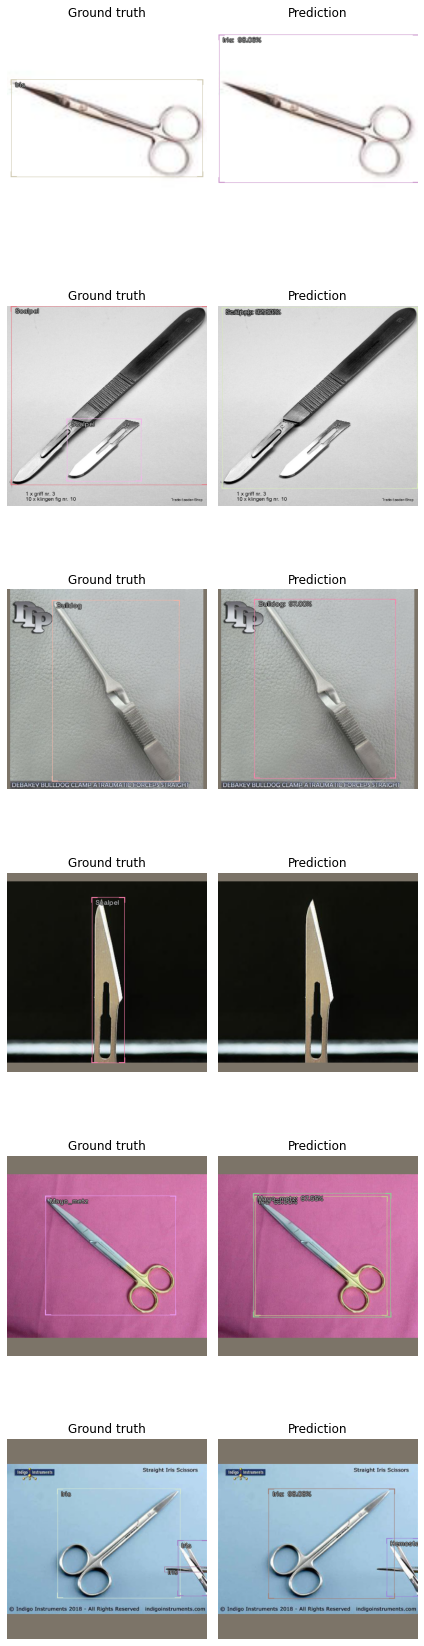

In [33]:
model_type.show_results(model, valid_ds)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


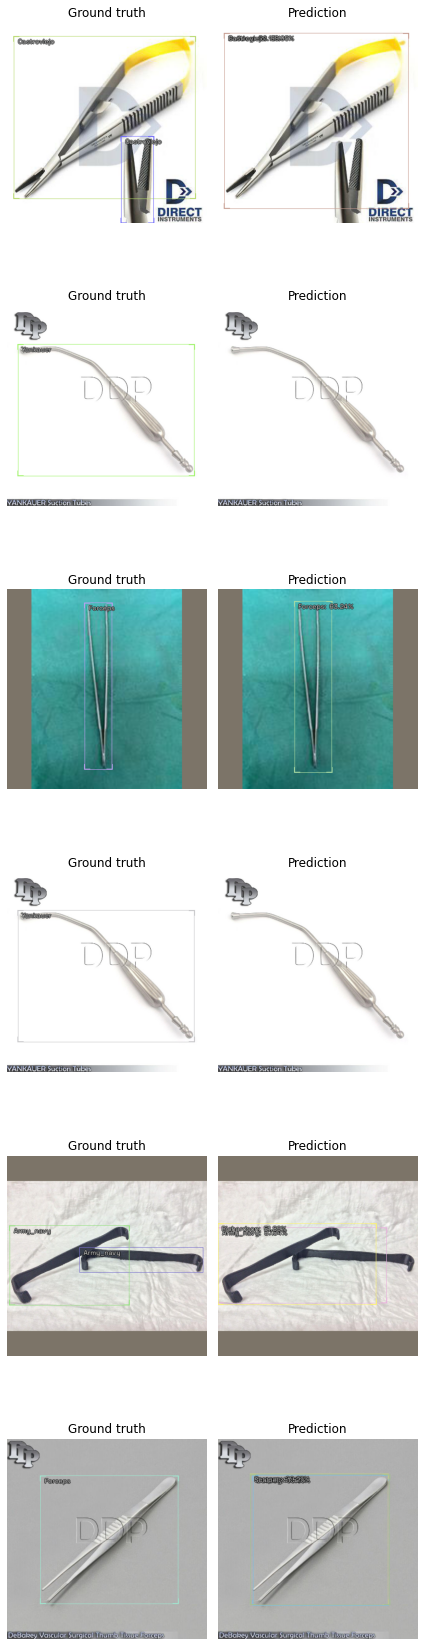

In [34]:
model_type.show_results(model, valid_ds)


In [35]:
from icevision.models import *

checkpoint_path = 'Model_E_ret_mAP47.5.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

# download model

Inference for Set_6

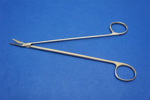

In [36]:
image_path = Path('Surgical_instruments/Sets/Set_6/raw_images')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[0]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [37]:
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)

In [38]:
imgs_array = [PIL.Image.open(file) for file in img_files]

imgs_array = [image.convert('RGB') for image in imgs_array]

img_size = 384 

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)

Use Model E (trained on Set_1_5)

In [ ]:
from icevision.models import *

checkpoint_path = 'Model_E_ret_mAP47.5.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)
model = checkpoint_and_model['model'] # Model E
model.eval()

Inference/ generate pseudolabels for Set_5 using Model D.

In [40]:
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)

preds_saved = model_type.predict_from_dl(model, infer_dl,
                                          keep_images=True, 
                                         detection_threshold = 0.5) ##

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


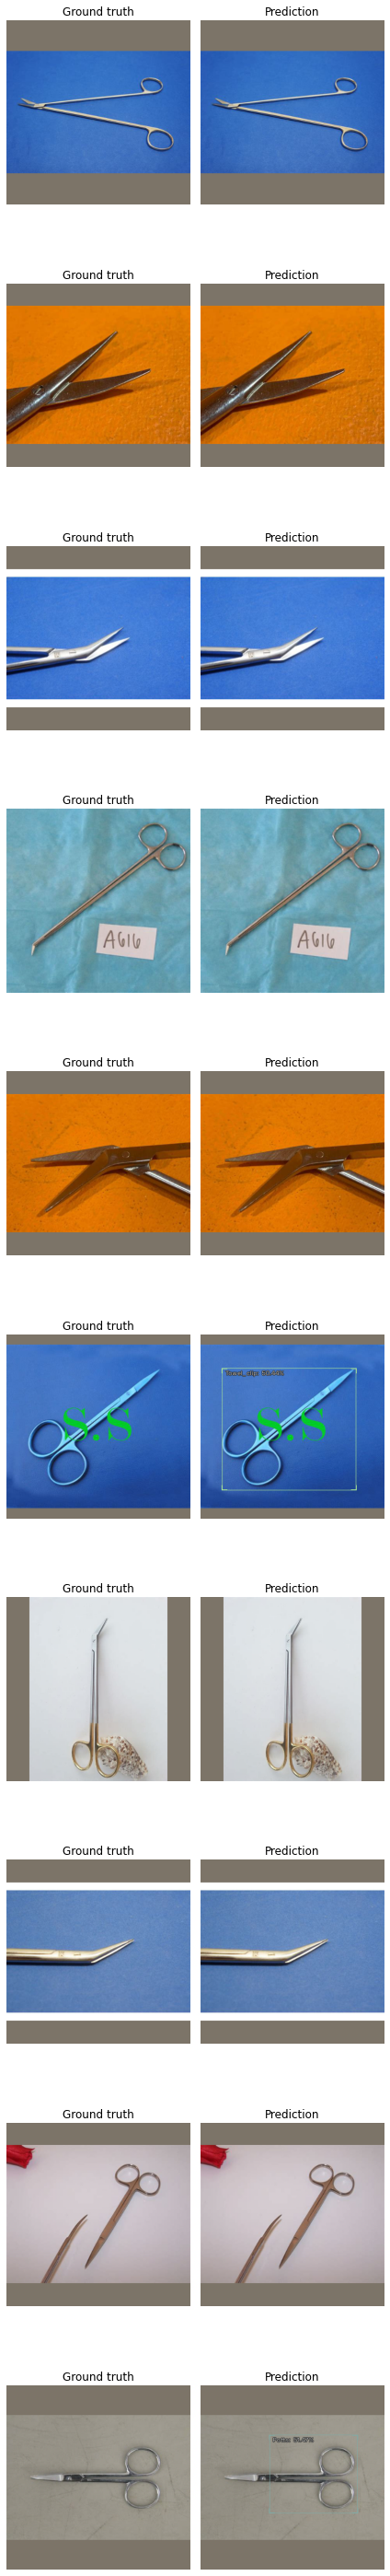

In [41]:
show_preds(preds = preds_saved[0:10])
# with detection threshold 0.5

Fair pseudolabels: a few fair bboxes, poor classification.

Don't use for pseudolabels.


In [ ]:
# skip

for pred in preds_saved:
  pred.add_component(FilepathRecordComponent())

for _ in range(len(preds_saved)): 
  preds_saved[_].set_filepath(img_files[_]) 

conv = convert_preds_to_coco_style(preds_saved) 

In [ ]:
# skip
add_info = {
    "info": {
        "year": "2021",
        "version": "1",
        "description": "Exported from roboflow.ai",
        "contributor": "",
        "url": "https://public.roboflow.ai/object-detection/undefined",
        "date_created": "2021-10-05T20:13:09+00:00"
    },
    "licenses": [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0"
        }
    ],
    "categories": [
        {
            "id": 0,
            "name": "instruments",
            "supercategory": "none"
        },
        {
            "id": 1,
            "name": "Army_navy",
            "supercategory": "Retractor"
        },
        {
            "id": 2,
            "name": "Bulldog",
            "supercategory": "Clamp"
        },
        {
            "id": 3,
            "name": "Castroviejo",
            "supercategory": "Needle_holder"
        },
        {
            "id": 4,
            "name": "Forceps",
            "supercategory": "Forceps"
        },
        {
            "id": 5,
            "name": "Frazier",
            "supercategory": "Suction"
        },
        {
            "id": 6,
            "name": "Hemostat",
            "supercategory": "Clamp"
        },
        {
            "id": 7,
            "name": "Iris",
            "supercategory": "Scissors"
        },
       {
            "id": 8,
            "name": "Mayo_metz",
            "supercategory": "Scissors"
        },
        {
            "id": 9,
            "name": "Needle",
            "supercategory": "Needle"
        },
        {
            "id": 10,
            "name": "Potts",
            "supercategory": "Scissors"
        },
        {
            "id": 11,
            "name": "Richardson",
            "supercategory": "Retractor"
        },
        {
            "id": 12,
            "name": "Scalpel",
            "supercategory": "Scalpel"
        },
        {
            "id": 13,
            "name": "Towel_clip",
            "supercategory": "Clamp"
        },
        {
            "id": 14,
            "name": "Weitlaner",
            "supercategory": "Retractor"
        },
        {
            "id": 15,
            "name": "Yankauer",
            "supercategory": "Suction"
        }
    ]
}

In [ ]:
# skip
pseudo = {**add_info, **conv}

f = open('pseudo.json','w') 
f.write(str(pseudo)) 
f.close()
##  edit ' to "": annot_.json

Do annotation and split in Roboflow.

Continue iterative training.